In [1]:
comment = 'calculated in Lattice2D_sim.ipynb'

In [2]:
%matplotlib inline
#%matplotlib notebook
import numpy as np
import pandas as pd
import math
import os
import matplotlib.pyplot as plt
#from tqdm import tqdm
from tqdm.notebook import tqdm

In [3]:
from HigherOrderPathGenerator import CrossValidation_HigherOrderPathGenerator
from Embedding import HON_DeepWalk_Embedding, HON_Node2vec_Embedding, HONEM_Embedding, HON_NetMF_Embedding, HON_GraRep_Embedding, HON_Transition_Hierarchical_Embedding
from SyntheticNetworks import create_lattice_2nd_order_dynamic
#from Visualizations import Visualization, EmbeddingView, Lattice2D_EmbeddingView

In [4]:
size = 10
omega = 0.5
gen = create_lattice_2nd_order_dynamic(size, omega, lattice_sep='-', check=True)

[]
[]


In [5]:
if not os.path.exists('tmp'):
    os.makedirs('tmp')

In [6]:
def iter_cross_prod(**kwargs):
    total_len = np.prod([len(v) for v in kwargs.values()])
    for i in tqdm(range(total_len)):
        current = dict()
        #for k,v in kwargs.items(): # simpler, but wrong order
        #    current[k] = v[i % len(v)]
        #    i = i // len(v)
        j = total_len
        for k,v in kwargs.items():
            j = j // len(v) # = product of lengths over remaining items
            current[k] = v[i // j]
            i = i % j
        yield current

In [7]:
# verifying order of iteration
for current in iter_cross_prod(a=[1,2], b=[3,4,5], c=[6,7]):
    print(current)

{'a': 1, 'b': 3, 'c': 6}
{'a': 1, 'b': 3, 'c': 7}
{'a': 1, 'b': 4, 'c': 6}
{'a': 1, 'b': 4, 'c': 7}
{'a': 1, 'b': 5, 'c': 6}
{'a': 1, 'b': 5, 'c': 7}
{'a': 2, 'b': 3, 'c': 6}
{'a': 2, 'b': 3, 'c': 7}
{'a': 2, 'b': 4, 'c': 6}
{'a': 2, 'b': 4, 'c': 7}
{'a': 2, 'b': 5, 'c': 6}
{'a': 2, 'b': 5, 'c': 7}



In [8]:
def get_stretch_ratio(emb, edge_distance = 1):
    ev = emb.source ## emb._data if emb._symmetric else emb.source
    ev.edge_distance=edge_distance # this may affect other plots
    hor_edges_len = np.linalg.norm(ev.node_embedding_diff(ev._hor_edge_pairs),axis=1)
    ver_edges_len = np.linalg.norm(ev.node_embedding_diff(ev._ver_edge_pairs),axis=1)
    return ver_edges_len.mean()/hor_edges_len.mean() # = ev.config['stretch']

In [9]:
def disp_marginals(df, emb=None, title=None, figsize=(12,3), dpi=200, bbox_inches='tight', filename=None, exclude_FON=True):
    "average stretch_ratio grouped by the values of each parameter"
    cols = sorted(set(df.columns) - {'stretch_ratio','name','q', 'p', 'num_walks'})
    p_vals = sorted(df['p'].unique()) if 'p' in df.columns else [None]
    if exclude_FON:
        if 'window_size' in df.columns:
            df = df[df['window_size']>1]
        if 'num_steps' in df.columns:
            df = df[df['num_steps']>1]
    fig,axs = plt.subplots(nrows=1, ncols=len(cols), sharey=True, figsize=figsize, dpi=dpi)
    if title is not None:
        fig.suptitle(title)
    for c,ax in zip(cols, axs):
        for p in p_vals:
            df_p = df if p is None else df[df['p']==p]
            avgs = df_p.groupby(c)['stretch_ratio'].mean().sort_index()
            x_vals = avgs.index
            y_vals = avgs.values
            label = None if p is None else 'p='+str(p)
            ax.plot(x_vals, y_vals, label=label)
            if p is None:
                y_min = df_p.groupby(c)['stretch_ratio'].min().sort_index().values
                y_max = df_p.groupby(c)['stretch_ratio'].max().sort_index().values
                ax.fill_between(x_vals, y_min, y_max, alpha=0.1)
            ax.set_xlabel(c)
            if c == 'dimension' or c == 'factor':
                ax.set_xticks(x_vals)
    axs[0].set_ylabel('stretch_ratio')
    if len(p_vals) > 1:
        axs[0].legend()
    if filename is not None:
        fig.savefig(filename, bbox_inches=bbox_inches)
        with open(filename + '.txt','w') as f:
            if comment != '':
                f.write(comment + '\n\n')
            f.write('Params:\n')
            for c in cols:
                vals = sorted(df[c].unique())
                f.write(f'{c}\t{vals}\n')
            f.write('\nMarginals:\n')
            for c in cols:
                f.write(str(df.groupby(c)['stretch_ratio'].agg(['min','mean','max']))+'\n')
            if emb is not None:
                emb.write_config(f, comment=comment, prefix='', sep='\t')
            f.write('\nTop 10:\n')
            df = df.sort_values('stretch_ratio', ascending=False)
            f.write(str(df.head(10))+'\n')
            f.write('\nBottom 10:\n')
            f.write(str(df.tail(10))+'\n')

## NetMF

,stretch_ratio,name,dimension,window_size,negative
190,1.625259,NetMF,16,20,1
180,1.617602,NetMF,16,19,1
170,1.613885,NetMF,16,18,1
160,1.603629,NetMF,16,17,1
150,1.598398,NetMF,16,16,1
140,1.583151,NetMF,16,15,1
130,1.572799,NetMF,16,14,1
120,1.555671,NetMF,16,13,1
350,1.551912,NetMF,32,16,1
310,1.549661,NetMF,32,12,1


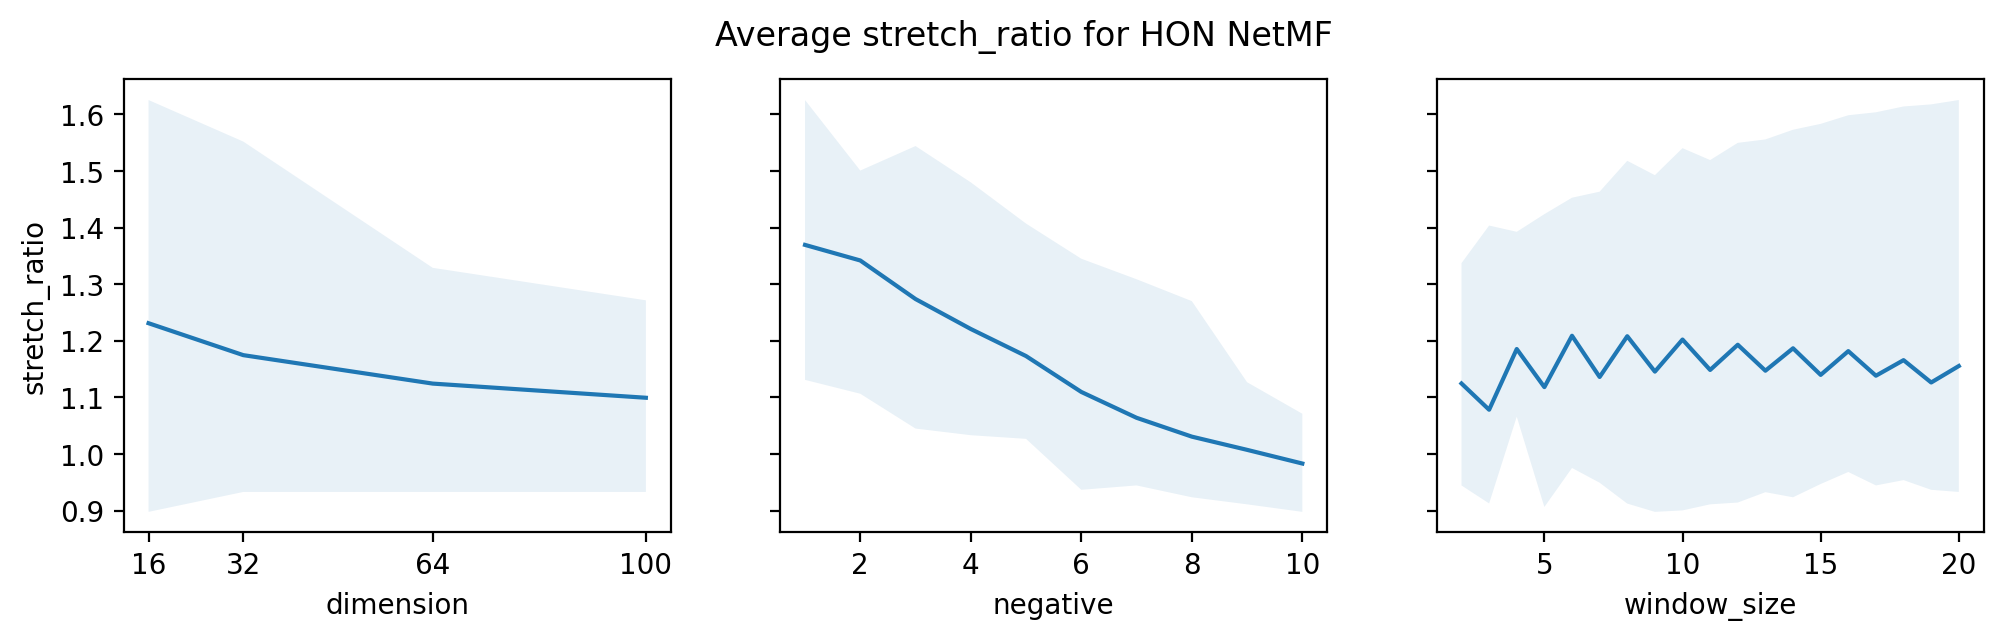

In [10]:
# NetMF: figure 4.1 (top row)
res_NetMF = []
emb = None
# loop over dimension and window_size first to allow NetMF to reuse its PMI calculation.
for current in iter_cross_prod(dimension=[16, 32, 64, 100], window_size=range(1,21), negative=range(1,11)):
    if (emb is None) or (emb._dimension!=current['dimension']):
        emb = HON_NetMF_Embedding(gen, dimension=current['dimension'], pairwise=True)
    emb.train(window_size=current['window_size'], negative=current['negative'])
    stetch = get_stretch_ratio(emb,      edge_distance = 1)
    config = dict(stretch_ratio=stetch, name='NetMF')
    config.update(current)
    res_NetMF.append(config)
res_NetMF = pd.DataFrame(res_NetMF).sort_values('stretch_ratio', ascending=False)
disp_marginals(res_NetMF, emb, title='Average stretch_ratio for HON NetMF', filename='tmp/stretch_sim_NetMF.png')
res_NetMF.head(10)

In [11]:
res_NetMF[res_NetMF['window_size']==2].head()

,stretch_ratio,name,dimension,window_size,negative
11,1.337149,NetMF,16,2,2
10,1.309763,NetMF,16,2,1
12,1.302841,NetMF,16,2,3
211,1.275984,NetMF,32,2,2
210,1.258308,NetMF,32,2,1


## HONEM

,stretch_ratio,name,dimension,dummy
0,1.327574,HONEM,16,1
1,1.207816,HONEM,32,1
2,1.121258,HONEM,64,1
3,1.087279,HONEM,100,1


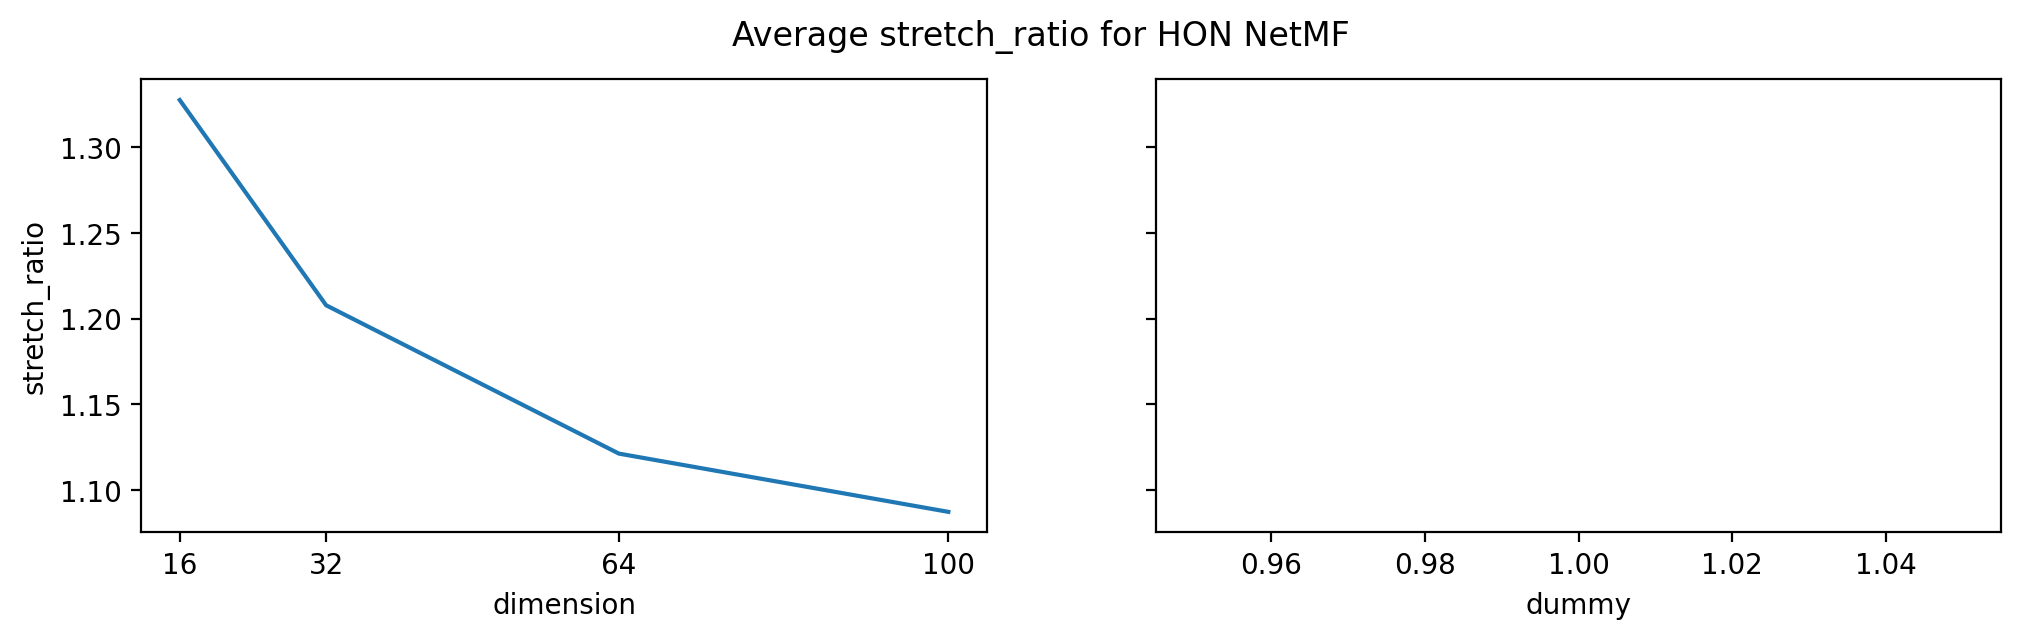

In [12]:
# HONEM: plot not shown in thesis
res_HONEM = []
emb = None
# disp_marginals requires at least two parameters
for current in iter_cross_prod(dimension=[16, 32, 64, 100], dummy=[1]):
    emb = HONEM_Embedding(gen, dimension=current['dimension'])
    emb.train()
    stetch = get_stretch_ratio(emb)
    config = dict(stretch_ratio=stetch, name='HONEM')
    config.update(current)
    res_HONEM.append(config)
res_HONEM = pd.DataFrame(res_HONEM).sort_values('stretch_ratio', ascending=False)
disp_marginals(res_HONEM, emb, title='Average stretch_ratio for HON NetMF', filename='tmp/stretch_sim_HONEM.png')
res_HONEM.head(10)

# DeepWalk & Node2vec

In [13]:
# DeepWalk -> see Node2vec(p=1=q)
if False:
    res_DW = []
    emb = None
    dw_train_param = dict(num_iter=5, random_seed=100)
    # loop over dimension, window_size, and factor first to allow DeepWalk to reuse its random walks
    for current in iter_cross_prod(dimension=[16, 32, 64, 100], window_size=range(1,21), factor=[1,2,4], negative=range(1,11)):
        if (emb is None) or (emb._dimension!=current['dimension']):
            emb = HON_DeepWalk_Embedding(gen, current['dimension'], reuse_walks=True)
        window_size = current['window_size']
        negative = current['negative']
        factor = current['factor']
        emb.train(num_walks=1000//window_size, walk_length=factor*window_size, window_size=window_size, hs=False, negative=negative, **dw_train_param)
        stretch = get_stretch_ratio(emb)
        config = dict(stretch_ratio=stretch, name='DeepWalk')
        config.update(current)
        res_DW.append(config)
    res_DW = pd.DataFrame(res_DW).sort_values('stretch_ratio', ascending=False)
    disp_marginals(res_DW, emb, title='Average stretch_ratio for HON DeepWalk', filename='tmp/stretch_sim_DW.png')
    res_DW.head(10)

,stretch_ratio,name,q,p,dimension,window_size,factor,negative
7020,1.429127,Node2vec,0.50,2.0,100,15,1,1
6960,1.423564,Node2vec,0.50,2.0,100,13,1,1
7170,1.423256,Node2vec,0.50,2.0,100,20,1,1
9480,1.422642,Node2vec,0.25,4.0,100,17,1,1
9300,1.422439,Node2vec,0.25,4.0,100,11,1,1
7080,1.419592,Node2vec,0.50,2.0,100,17,1,1
6420,1.417713,Node2vec,0.50,2.0,64,15,1,1
6900,1.417473,Node2vec,0.50,2.0,100,11,1,1
7050,1.416941,Node2vec,0.50,2.0,100,16,1,1
6930,1.415657,Node2vec,0.50,2.0,100,12,1,1


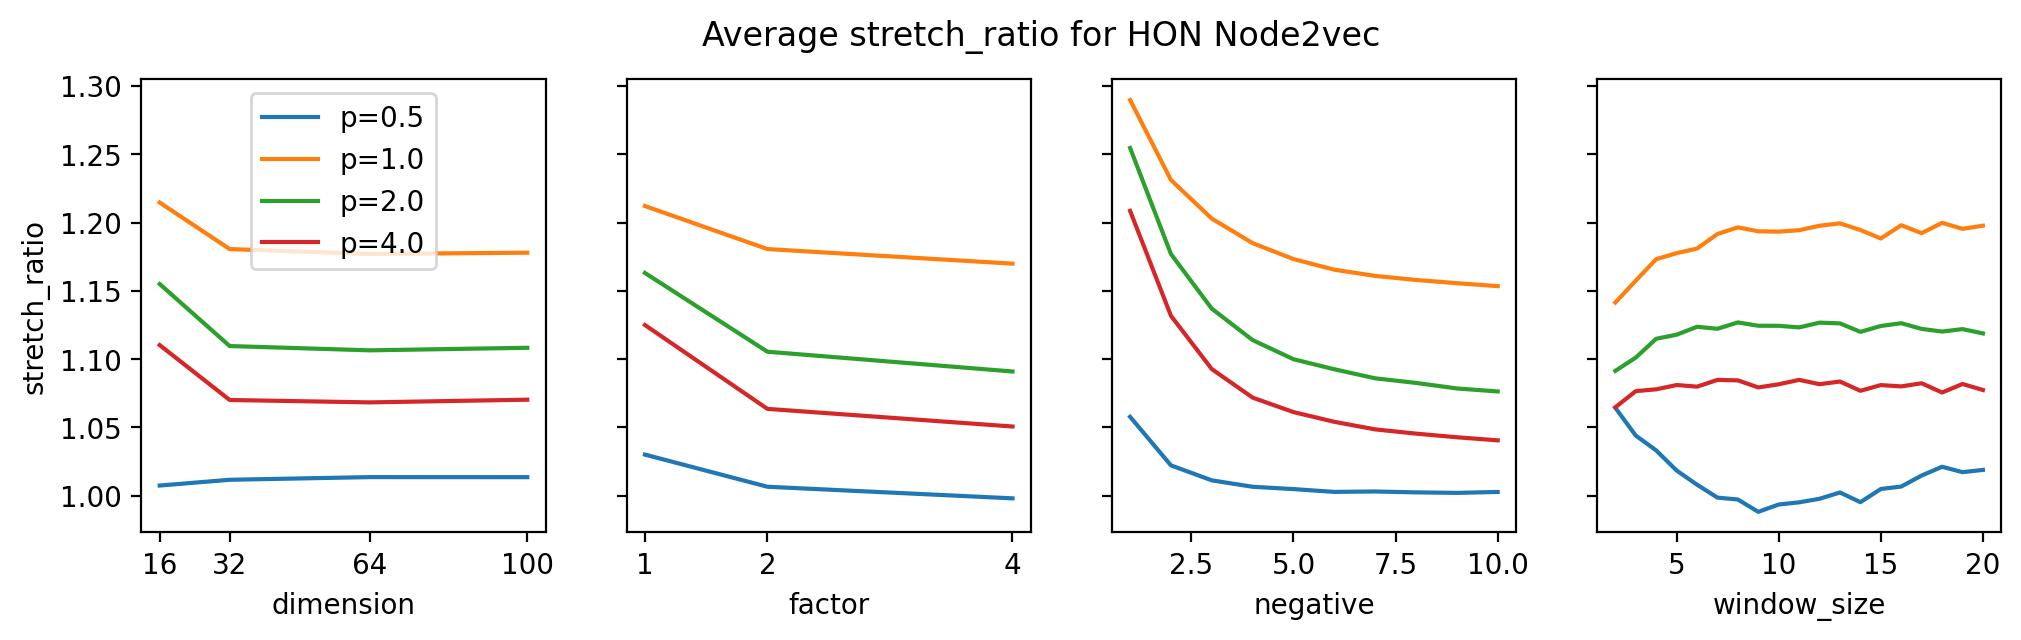

In [14]:
# Node2vec (7 hrs): figure 4.1 (bottom)
res_N2V = []
n2v_train_param = dict(num_iter=5, random_seed=100)
emb = None
for current in iter_cross_prod(p=[0.5,1,2,4], dimension=[16, 32, 64, 100], window_size=range(1,21), factor=[1,2,4], negative=range(1,11)):
    if (emb is None) or (emb._dimension!=current['dimension']) or (emb._gen._p!=current['p']):
        emb = HON_Node2vec_Embedding(gen, current['dimension'], p=current['p'], q=1/current['p'], reuse_walks=True)
    window_size = current['window_size']
    negative = current['negative']
    factor = current['factor']
    emb.train(num_walks=1000//window_size, walk_length=factor*window_size, window_size=window_size, hs=False, negative=negative, **n2v_train_param)
    stretch = get_stretch_ratio(emb)
    config = dict(stretch_ratio=stretch, name='Node2vec', q=1/current['p'])
    config.update(current)
    res_N2V.append(config)
res_N2V = pd.DataFrame(res_N2V).sort_values('stretch_ratio', ascending=False)
disp_marginals(res_N2V, emb, title='Average stretch_ratio for HON Node2vec', filename='tmp/stretch_sim_N2V.png')
res_N2V.head(10)

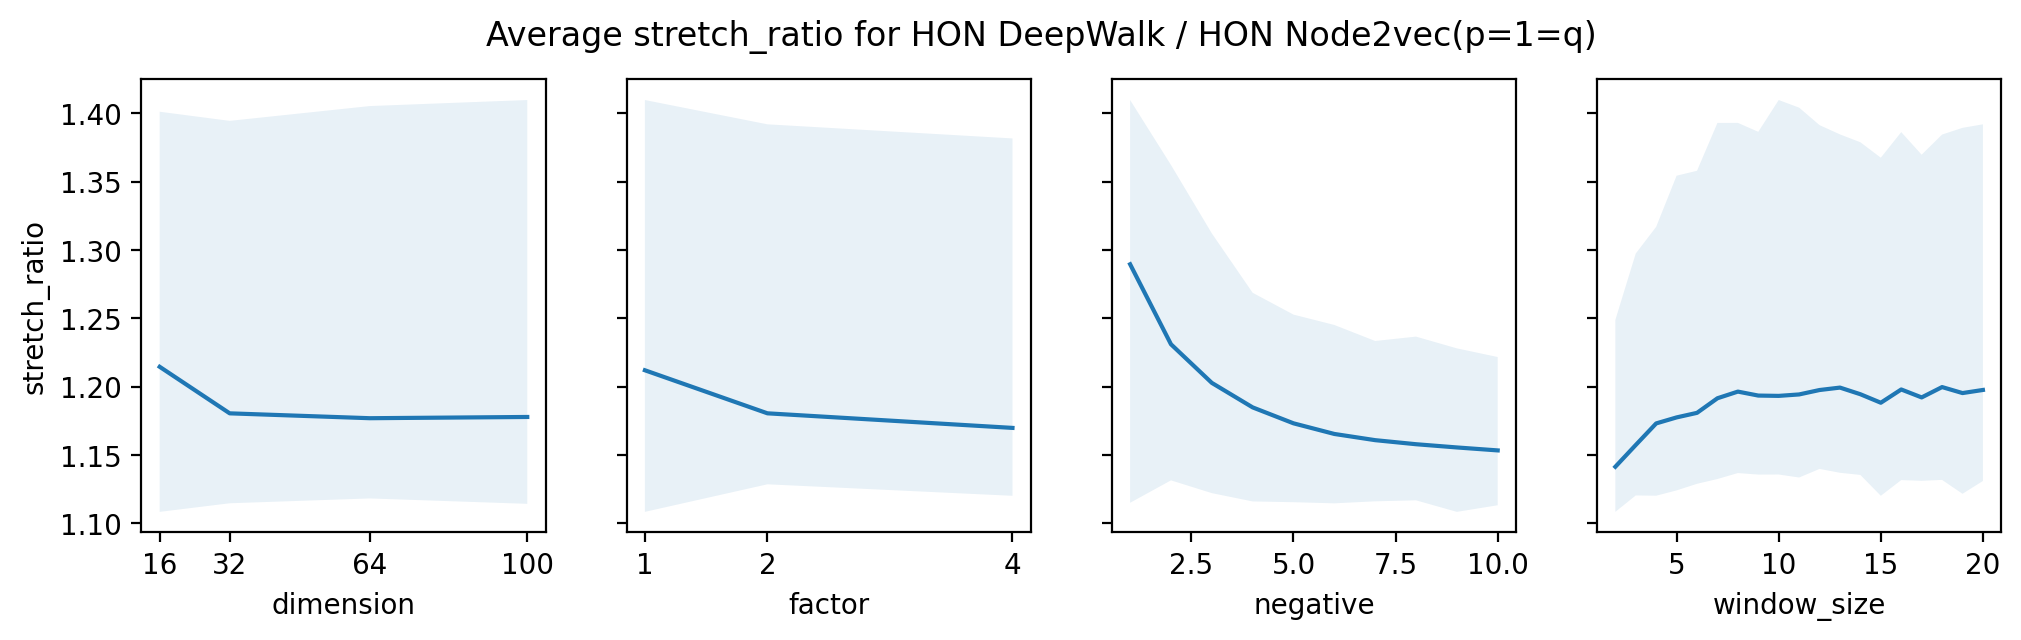

In [15]:
# DeepWalk: figure 4.1 (3rd row)
res_DW = res_N2V[res_N2V['p']==1].drop(['p','q'], axis=1)
res_DW['name'] = 'DeepWalk'
disp_marginals(res_DW, title='Average stretch_ratio for HON DeepWalk / HON Node2vec(p=1=q)', filename='tmp/stretch_sim_DW.png')

In [16]:
res_DW[res_DW['window_size']==2].head()

,stretch_ratio,name,dimension,window_size,factor,negative
3640,1.248872,DeepWalk,64,2,2,1
2440,1.248437,DeepWalk,16,2,2,1
4240,1.248239,DeepWalk,100,2,2,1
3040,1.242888,DeepWalk,32,2,2,1
4241,1.188573,DeepWalk,100,2,2,2


In [17]:
def disp_stretch_W(df, emb=None, title=None, figsize=(12,3), dpi=200, bbox_inches='tight', filename=None):
    df = df.sort_values('window_size')
    fig =plt.figure(figsize=figsize, dpi=dpi)
    if title is not None:
        fig.suptitle(title)
    ax = fig.gca()
    ax.plot(df['window_size'], df['stretch_ratio'])
    ax.set_xlabel('window_size')
    ax.set_ylabel('stretch_ratio')
    if filename is not None:
        fig.savefig(filename, bbox_inches=bbox_inches)
        with open(filename + '.txt','w') as f:
            if comment != '':
                f.write(comment + '\n\n')
            if emb is not None:
                emb.write_config(f, comment=comment, prefix='', sep='\t')
            f.write('\nData:\n')
            f.write(df[['window_size','stretch_ratio']].sort_values('stretch_ratio', ascending=False).to_csv(index=False,line_terminator='\n'))

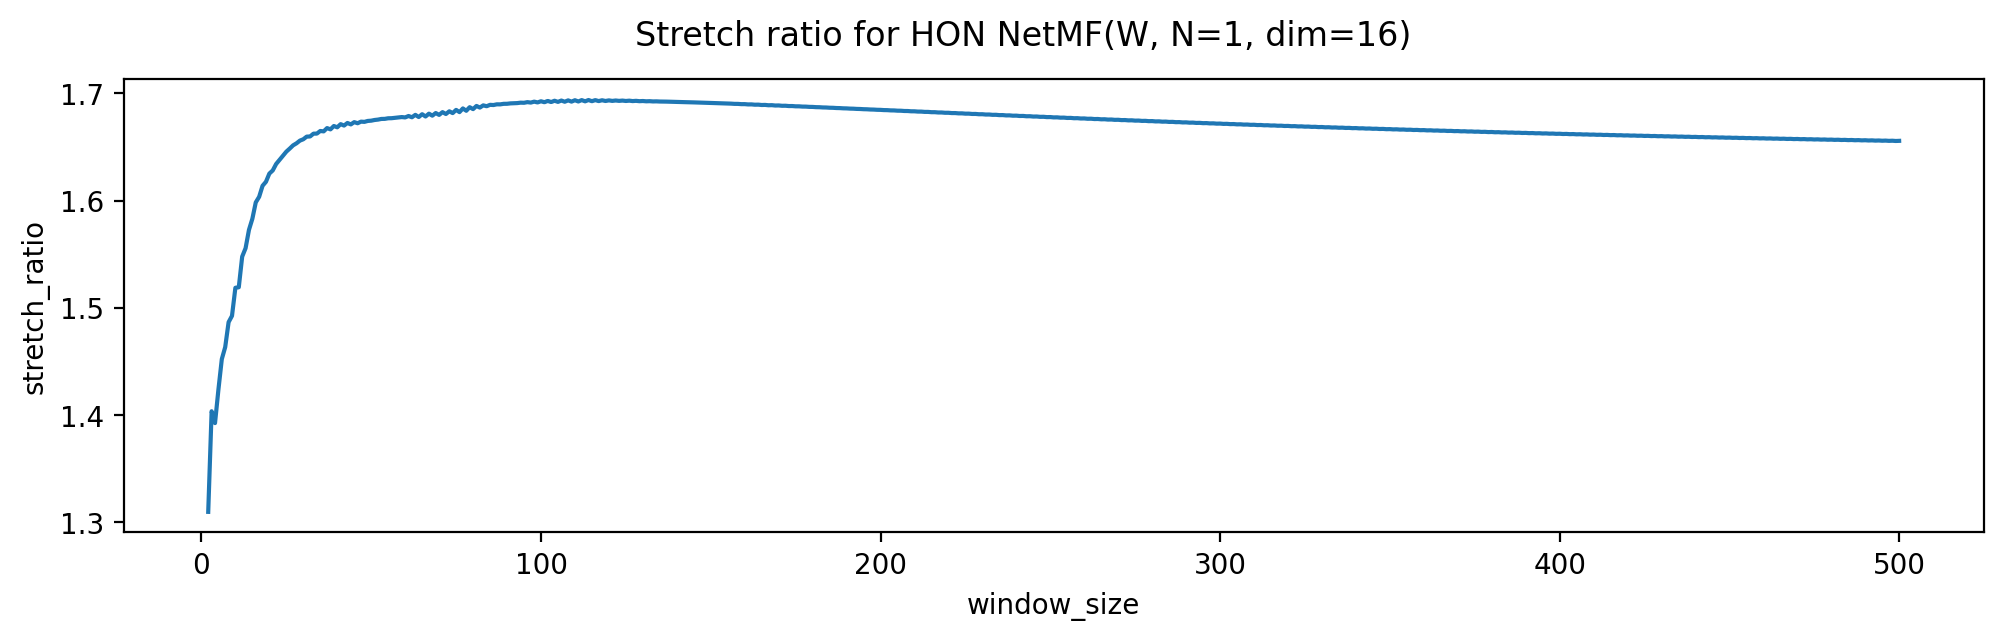

In [18]:
# NetMF (getting the optimal window size, 4 hrs 30 mins): figure 4.4
if True:
    res_NetMF2 = []
    emb = None
    # loop over dimension and window_size first to allow NetMF to reuse its PMI calculation.
    for current in iter_cross_prod(dimension=[16], window_size=range(2,501), negative=[1]):
        if (emb is None) or (emb._dimension!=current['dimension']):
            emb = HON_NetMF_Embedding(gen, dimension=current['dimension'], pairwise=True)
        emb.train(window_size=current['window_size'], negative=current['negative'])
        stretch = get_stretch_ratio(emb)
        config = dict(stretch_ratio=stretch, name='NetMF')
        config.update(current)
        res_NetMF2.append(config)
    res_NetMF2 = pd.DataFrame(res_NetMF2).sort_values('stretch_ratio', ascending=False)
    disp_stretch_W(res_NetMF2, emb, title='Stretch ratio for HON NetMF(W, N=1, dim=16)', filename='tmp/stretch_sim_NetMF_by_W.png')
    res_NetMF2.head(10)

## GraRep

,stretch_ratio,name,dimension,num_steps,negative
192,1.675333,GraRep,16,20,3
182,1.672941,GraRep,16,19,3
172,1.670062,GraRep,16,18,3
162,1.666023,GraRep,16,17,3
152,1.661274,GraRep,16,16,3
142,1.654845,GraRep,16,15,3
132,1.646969,GraRep,16,14,3
122,1.636951,GraRep,16,13,3
191,1.631141,GraRep,16,20,2
181,1.625245,GraRep,16,19,2


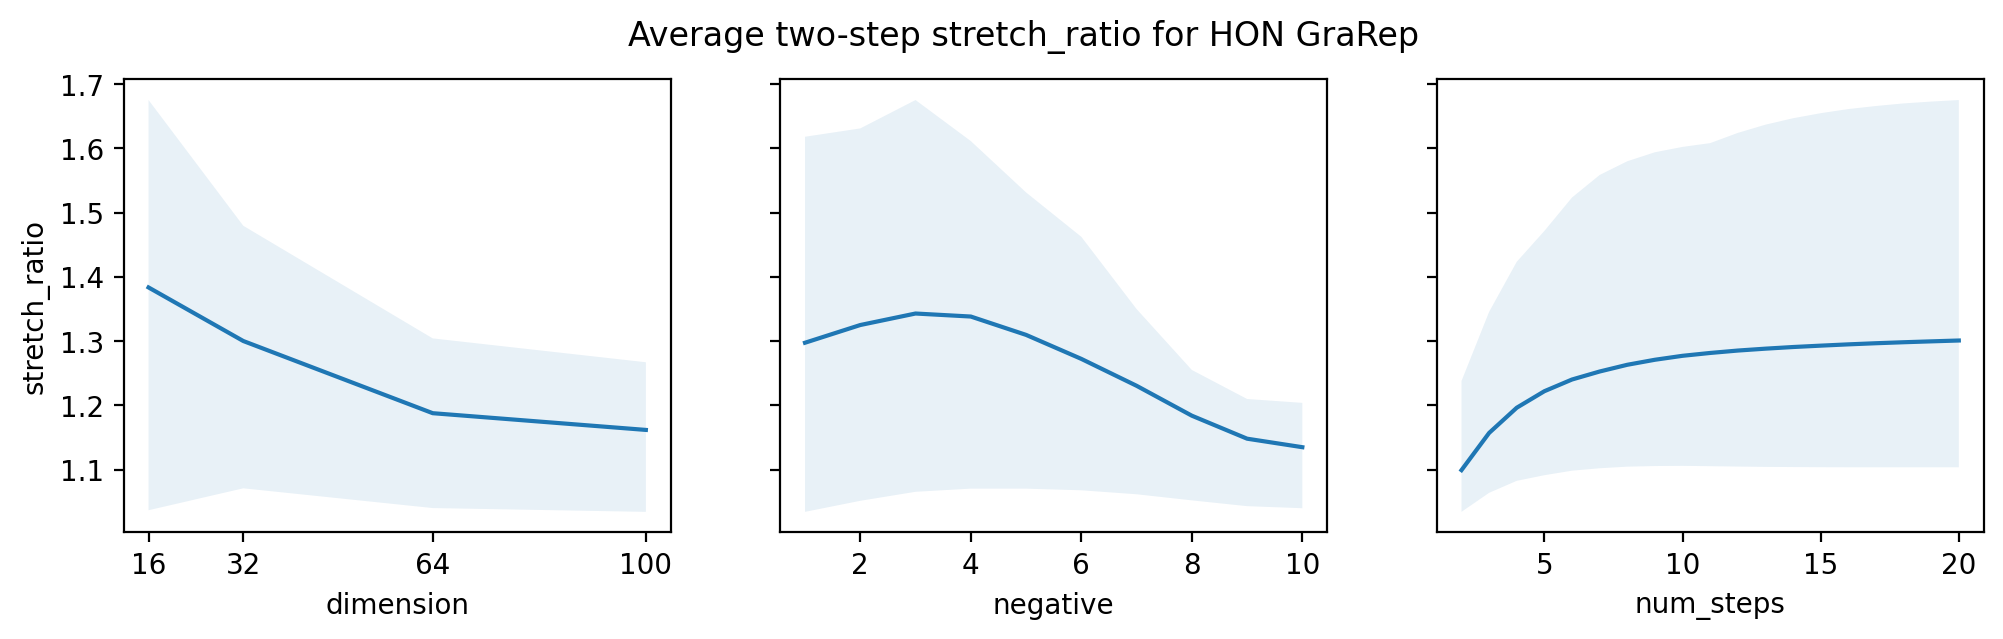

In [19]:
import warnings
# GraRep: figure 4.1 (2nd row)
res_GraRep = []
emb = None
# loop over dimension and window_size first to allow NetMF to reuse its PMI calculation.
for current in iter_cross_prod(dimension=[16, 32, 64, 100], num_steps=range(1,21), negative=range(1,11)):
    if (emb is None) or (emb._dimension!=current['dimension']) or (emb._num_steps!=current['num_steps']):
        emb = HON_GraRep_Embedding(gen, dimension=current['dimension'], num_steps=current['num_steps'], pairwise=True)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        emb.train(negative=current['negative'])
    stretch = get_stretch_ratio(emb, edge_distance=2)
    config = dict(stretch_ratio=stretch, name='GraRep')
    config.update(current)
    res_GraRep.append(config)
res_GraRep = pd.DataFrame(res_GraRep).sort_values('stretch_ratio', ascending=False)
disp_marginals(res_GraRep, emb, title='Average two-step stretch_ratio for HON GraRep', filename='tmp/stretch_sim_GraRep.png')
res_GraRep.head(10)

In [20]:
res_GraRep[res_GraRep['num_steps']==2].head()

,stretch_ratio,name,dimension,num_steps,negative
13,1.237977,GraRep,16,2,4
14,1.235931,GraRep,16,2,5
12,1.235618,GraRep,16,2,3
15,1.228402,GraRep,16,2,6
11,1.222282,GraRep,16,2,2


In [21]:
res_DW2 = []
emb = None
dw_train_param = dict(num_iter=5, random_seed=100)
# loop over dimension, window_size, and factor first to allow DeepWalk to reuse its random walks
for current in iter_cross_prod(dimension=[32, 64, 100], window_size=range(1,11), factor=[1,2], negative=range(1,51)):
    if (emb is None) or (emb._dimension!=current['dimension']):
        emb = HON_DeepWalk_Embedding(gen, current['dimension'], reuse_walks=True)
    window_size = current['window_size']
    negative = current['negative']
    factor = current['factor']
    emb.train(num_walks=1000//window_size, walk_length=factor*window_size, window_size=window_size, hs=False, negative=negative, **dw_train_param)
    stretch = get_stretch_ratio(emb)
    config = dict(stretch_ratio=stretch, name='DeepWalk')
    config.update(current)
    res_DW2.append(config)
res_DW2 = pd.DataFrame(res_DW2).sort_values('stretch_ratio', ascending=False)
res_DW2.head(10)

,stretch_ratio,name,dimension,window_size,factor,negative
2900,1.409850,DeepWalk,100,10,1,1
1900,1.405432,DeepWalk,64,10,1,1
900,1.394603,DeepWalk,32,10,1,1
2700,1.393129,DeepWalk,100,8,1,1
2600,1.393086,DeepWalk,100,7,1,1
1700,1.390592,DeepWalk,64,8,1,1
1600,1.390360,DeepWalk,64,7,1,1
2800,1.386586,DeepWalk,100,9,1,1
600,1.384790,DeepWalk,32,7,1,1
1800,1.383465,DeepWalk,64,9,1,1
